In [1]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import pandas as pd
from happyfuntokenizing import Tokenizer
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np

# 1. Community Detection

In [2]:
g = nx.Graph()
users = {}

In [3]:
# Process the file

file = 'friendships.txt'

with open(file, 'r') as f:
    lines = f.read().split('\n')
    
    for line in lines:
        if line.startswith('user: '):
            last_name_seen = line.split(' ')[1]
            users[last_name_seen] = []            
        elif line.startswith('friends:\t'):
            friends = line.split('\t')[1:]
            users[last_name_seen] += friends

In [4]:
# Create graph

g.add_nodes_from(list(users.keys()))

for user, friends in users.items():
    g.add_edges_from([[user, friend] for friend in friends])

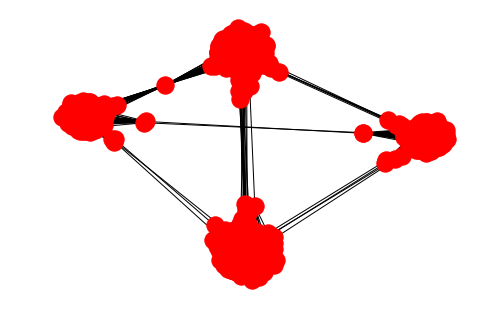

In [5]:
nx.draw(g)

In [6]:
# Calculate the communities
com_gen = community.girvan_newman(g)

In [7]:
# Calculate different levels of communities to compare
top_level = next(com_gen)
second_level = next(com_gen)
third_level = next(com_gen)

In [8]:
print('First level: {} communities of lengths: {}'.format(
    len(top_level), ''), 
    ', '.join([str(len(l)) for l in top_level])
)

print('Second level: {} communities of lengths: {}'.format(
    len(second_level), ''), 
    ', '.join([str(len(l)) for l in second_level])
)

print('Third level: {} communities of lengths: {}'.format(
    len(third_level), ''), 
    ', '.join([str(len(l)) for l in third_level])
)

First level: 2 communities of lengths:  1751, 2470
Second level: 3 communities of lengths:  1751, 683, 1787
Third level: 4 communities of lengths:  1751, 683, 1168, 619


# 2. Sentiment Analysis

## 2.1 Text data preprocessing

In [9]:
# Process the file

file = 'SentimentTrainingData.txt'
rows = []

with open(file, 'r') as f:
    blocks = f.read().split('\n\n')
    
    for block in blocks:
        new_line = {}
        for line in block.split('\n'):

            if line.startswith('review/userId: '):
                new_line['user'] = line.split(' ')[1]
            elif line.startswith('review/helpfulness: '):
                new_line['helpfulness'] = line.split(' ')[1]
            elif line.startswith('review/score: '):
                new_line['score'] = line.split(' ')[1]
            elif line.startswith('review/summary: '):
                new_line['summary'] = ' '.join(line.split(' ')[1:])
            elif line.startswith('review/text: '):
                new_line['text'] = ' '.join(line.split(' ')[1:])

        rows.append(new_line)

In [10]:
# Load data into dataset
df = pd.DataFrame(rows)

In [11]:
# Pott's sentiment aware tokenizer
tok = Tokenizer()

In [12]:
# Remove html tags, convert to lowercase, remove unnecessary characters
# https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

df['text'] = [REPLACE_NO_SPACE.sub("", line.lower()) for line in df['text']]
df['text'] = [REPLACE_WITH_SPACE.sub(" ", line) for line in df['text']]

In [13]:
# Tokenize reviews

df['text'] = [' '.join(tok.tokenize(x)) for x in df['text']]

In [14]:
df.head()

,helpfulness,score,summary,text,user
0,3/6,5.0,If you're worried about consitpation....,i purchased this formula but was worried after...,A3K3GNZWUYXRUT
1,1/3,1.0,THIS IS NOT ORGANIC!!! TOXIC hexane still in it!,reconsider this formula martek advertises this...,AFAWC4ZJ29YV1
2,4/10,1.0,shipping time is unreasonably long,i ordered this on 8 29 10 and it didnt ship ou...,AVUV2TE9UKTPU
3,1/5,1.0,Horribly Constipating,my child was exclusively breastfed for 4 1 2 m...,A2MWGBNJRJN57M
4,9/20,1.0,Constipation!!!!!,we breastfeed our month old boy but since his ...,A3A6QXIC8XCOJG


In [15]:
# Remove stopwords from texts

stopwords_list = stopwords.words('english')

df['text'] = [' '.join([word for word in text.split(' ') if word not in stopwords_list]) for text in df['text']]

In [16]:
# Create the bag of words

vectorizer = CountVectorizer(binary=True)
vectorizer.fit(list(df['text'].values))

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
# Vectorize the texts

X = vectorizer.transform(list(df['text'].values))

## 2.2 Train and evaluate the sentiment classifier

In [18]:
# Target scores

y = list(df['score'])

In [19]:
# Create the model instance

lr = LogisticRegression()

In [20]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# Calculate the accuracy using 4-fold cross validation

print(cross_val_score(lr, X, y, cv=4, n_jobs=4))

[0.76169466 0.76304122 0.77037239 0.7619242 ]


## 2.3 Evaluate model on file with testing data

In [22]:
# Process the file

file = 'SentimentTestingData.txt'
rows = []

with open(file, 'r') as f:
    blocks = f.read().split('\n\n')
    
    for block in blocks:
        new_line = {}
        for line in block.split('\n'):

            if line.startswith('review/userId: '):
                new_line['user'] = line.split(' ')[1]
            elif line.startswith('review/helpfulness: '):
                new_line['helpfulness'] = line.split(' ')[1]
            elif line.startswith('review/score: '):
                new_line['score'] = line.split(' ')[1]
            elif line.startswith('review/summary: '):
                new_line['summary'] = ' '.join(line.split(' ')[1:])
            elif line.startswith('review/text: '):
                new_line['text'] = ' '.join(line.split(' ')[1:])

        rows.append(new_line)

In [23]:
# Load data into dataset
df = pd.DataFrame(rows)

In [24]:
# Remove html tags, convert to lowercase, remove unnecessary characters
# https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

df['text'] = [REPLACE_NO_SPACE.sub("", line.lower()) for line in df['text']]
df['text'] = [REPLACE_WITH_SPACE.sub(" ", line) for line in df['text']]

In [25]:
# Tokenize reviews

df['text'] = [' '.join(tok.tokenize(x)) for x in df['text']]

In [26]:
# Remove stopwords from texts

stopwords_list = stopwords.words('english')

df['text'] = [' '.join([word for word in text.split(' ') if word not in stopwords_list]) for text in df['text']]

In [27]:
# Vectorize the texts

X = vectorizer.transform(list(df['text'].values))
y = list(df['score'])

In [28]:
# Calculate the accuracy using 4-fold cross validation

cross_val_score(lr, X, y, cv=4, n_jobs=4)

array([0.66227018, 0.6437425 , 0.66146459, 0.65092074])

# 3. Purchase prediction

## 3.1 Computing scores

In [29]:
# Process the file

file = 'friendships.reviews.txt'

data = []

with open(file, 'r') as f:
    blocks = f.read().split('\n\n')
    
    for block in blocks:
        new_line = {}
    
        for line in block.split('\n'):
            if line.startswith('user: '):
                new_line['user'] = ' '.join(line.split(' ')[1:])
            elif line.startswith('friends:\t'):
                new_line['friends'] = ','.join(line.split('\t')[1:])
            elif line.startswith('summary: '):
                line = ' '.join(line.split(' ')[1:])
                new_line['summary'] = line if line is not '*' else None
            elif line.startswith('review: '):
                line = ' '.join(line.split(' ')[1:])
                new_line['review'] = line if line is not '*' else None
        
        data.append(new_line)

In [30]:
df = pd.DataFrame(data)

In [31]:
# Filter out non-reviewed rows

reviews = pd.DataFrame(df[df['review'].notnull()])
nonreviewed = pd.DataFrame(df[~df['review'].notnull()])

In [32]:
# Vectorize reviews

reviews['review'] = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews['review']]
reviews['review'] = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews['review']]

reviews['review'] = [' '.join(tok.tokenize(x)) for x in reviews['review']]
reviews['review'] = [' '.join([word for word in text.split(' ') if word not in stopwords_list]) for text in reviews['review']]

X = vectorizer.transform(list(reviews['review'].values))

In [33]:
X

<1644x167571 sparse matrix of type '<class 'numpy.int64'>'
	with 53676 stored elements in Compressed Sparse Row format>

In [34]:
# Predict score

y = lr.predict(X)
reviews['score'] = y

In [35]:
nonreviewed['score'] = None

In [36]:
for user in np.array(nonreviewed['user']):
    # Get all friends
    friends = nonreviewed[nonreviewed['user'] == user]['friends'].values[0].split(',')
    
    # Filter out friends without reviews
    friends = [fr for fr in friends if fr in np.array(reviews['user'])]
    
    # Calculate score based on user's friends' scores
    scores = []
    for fr in friends:
        score = reviews[reviews['user'] == fr]['score'].values[0]
        if fr == 'kyle':
            for i in range(0, 10):
                scores.append(float(score))
        else:
            scores.append(float(score))
    
    # If no friends have reviews, assign neutral score 3
    score = 3
    if len(scores) > 0:
        score = sum(scores)/len(scores)
    
    id = nonreviewed[nonreviewed['user'] == user].index[0]
    nonreviewed.loc[id, 'score'] = score

In [37]:
# Purchase is positive in case of positive review

nonreviewed['purchase_pr'] = ['yes' if score > 3.0 else 'no' for score in nonreviewed['score']]

## 3.2 Comparing calculated scores to real data

In [38]:
# Process the file

file = 'friendships.reviews.results.txt'

data = []

with open(file, 'r') as f:
    blocks = f.read().split('\n\n')
    
    for block in blocks:
        new_line = {}
    
        for line in block.split('\n'):
            if line.startswith('user: '):
                new_line['user'] = ' '.join(line.split(' ')[1:])
            elif line.startswith('purchase: '):
                new_line['purchase'] = line.split(' ')[1]
            elif line.startswith('score: '):
                new_line['score'] = line.split(' ')[1]
        
        data.append(new_line)

In [39]:
df = pd.DataFrame(data)

In [40]:
# Join datasets on user

merged = pd.merge(df, nonreviewed, on='user')[['user', 'purchase', 'purchase_pr']]

In [41]:
# Calculate accuracy

real = np.array(merged['purchase'])
pred = np.array(merged['purchase_pr'])

acc = sum([1 if real[i] == pred[i] else 0 for i in range(len(real))])/len(real)

In [42]:
acc

0.9856310679611651